In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [10]:
import torch
from torchvision import datasets,models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
print(torch.__version__)

0.4.1


In [11]:
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)

5.3.0


In [0]:
!wget --no-check-certificate https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip && unzip flower_data -d flower_data/

In [0]:
data_dir = 'flower_data/flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [0]:
# TODO: Define your transforms for the training and validation sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = 32)

In [14]:
# TODO: Make Class List
class_names = train_data.classes
n_class = len(class_names)
print ("Number of classes: "+ str(n_class) + "\n")
print ("Classes: "+ str(class_names) + "\n")

Number of classes: 102

Classes: ['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']



In [0]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [15]:
from torchvision import models
model = models.resnet101(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.torch/models/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:02<00:00, 63563959.62it/s]


In [16]:
# A device-agnostic expression so that it automatically set to GPU if available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
# Import additional package to build the classifier
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim import lr_scheduler
from collections import OrderedDict

In [0]:
# TODO: Build and train your network

# Freeze the parametes so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

hidden_size = 1024

# CLASSIFIER #
classifier = nn.Sequential(OrderedDict([('fc1',nn.Linear(2048,hidden_size)),
                                        ('relu',nn.ReLU()),
                                        ('dropout',nn.Dropout(p=0.3)),
                                        ('fc2',nn.Linear(hidden_size,hidden_size)),
                                        ('relu',nn.ReLU()),
                                        ('dropout',nn.Dropout(p=0.3)),
                                        ('fc3',nn.Linear(hidden_size,102)),
                                        ('output', nn.LogSoftmax(dim=1))]))
model.fc = classifier
model.zero_grad()

In [0]:
# TODO: Save the checkpoint 
def save_model(model,epoch,optimizer):
    model.class_to_idx = train_data.class_to_idx
    state = {
          'epoch': epoch,
          'state_dict': model.state_dict(),
          'optimizer': optimizer.state_dict(),
          'classifier':classifier,
          'class_to_idx': model.class_to_idx
        }
    torch.save(state, 'model_flowerComplete.pt')

In [0]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_model(model,optim):
    state = torch.load('model_flowerComplete.pt')
    model.load_state_dict(state['state_dict'])
    optim.load_state_dict(state['optimizer'])
    model.class_to_idx = state['class_to_idx']
    return model,optim

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img_compose = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
    pil_img = PIL.Image.open(image)
    img = img_compose(pil_img)
    
    
    return img

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # DONE: Implement the code to predict the class from an image file
    
    # evaluation mode
    # https://pytorch.org/docs/stable/nn.html#torch.nn.Module.eval
    model.eval()
    
    # cpu mode
    model.cpu()
    
    # load image as torch.Tensor
    image = process_image(image_path)
    
    # Unsqueeze returns a new tensor with a dimension of size one
    # https://pytorch.org/docs/stable/torch.html#torch.unsqueeze
    image = image.unsqueeze(0)
    
    # Disabling gradient calculation 
    # (not needed with evaluation mode?)
    with torch.no_grad():
        output = model.forward(image)
        top_prob, top_labels = torch.topk(output, topk)
        
        # Calculate the exponentials
        top_prob = top_prob.exp()
        
    class_to_idx_inv = {model.class_to_idx[k]: k for k in model.class_to_idx}
    mapped_classes = list()
    
    for label in top_labels.numpy()[0]:
        mapped_classes.append(class_to_idx_inv[label])
        
    return top_prob.numpy()[0], mapped_classes

In [23]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(),lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
if train_on_gpu:
  model = model.cuda()
  
n_epoch = 8

for epoch in range(1,n_epoch+1):
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0
    train_total = 0.0
    valid_total = 0.0
    # TRAIN #
    model.train()
    for data,target in train_loader:
        if train_on_gpu:
            data,target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model.forward(data)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        _, pred = torch.max(output.data, 1)
        train_loss += loss.item()
        train_total += target.size(0)
        train_acc += (pred == target).sum().item()
        
    # EVAL #
    model.eval()
    with torch.no_grad():
        for data,target in valid_loader:
            if train_on_gpu:
                data,target = data.cuda(), target.cuda()
            output = model.forward(data)
            loss = criterion(output, target)
            valid_loss += loss.item()
            # convert output probabilities to predicted class
            _, pred = torch.max(output, 1)    
            valid_total += target.size(0)
            valid_acc += (pred == target).sum().item()

    # AVERAGE LOSSES #
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    # AVERAGE ACCURACY #
    train_acc = (train_acc/train_total)*100
    valid_acc = (valid_acc/valid_total)*100
     
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \n \t \tTraining Acc: {:.2f}% \t\tValidation Acc: {:.2f}%'.format(
        epoch, train_loss, valid_loss, train_acc, valid_acc))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        save_model(model,epoch,optimizer)
        valid_loss_min = valid_loss
        print("")

Epoch: 1 	Training Loss: 0.047079 	Validation Loss: 0.023578 
 	 	Training Acc: 58.47% 		Validation Acc: 81.17%
Validation loss decreased (inf --> 0.023578).  Saving model ...

Epoch: 2 	Training Loss: 0.042740 	Validation Loss: 0.020115 
 	 	Training Acc: 61.94% 		Validation Acc: 82.76%
Validation loss decreased (0.023578 --> 0.020115).  Saving model ...

Epoch: 3 	Training Loss: 0.042898 	Validation Loss: 0.020637 
 	 	Training Acc: 62.24% 		Validation Acc: 83.86%
Epoch: 4 	Training Loss: 0.042476 	Validation Loss: 0.022916 
 	 	Training Acc: 62.90% 		Validation Acc: 80.07%
Epoch: 5 	Training Loss: 0.041717 	Validation Loss: 0.018464 
 	 	Training Acc: 63.55% 		Validation Acc: 84.23%
Validation loss decreased (0.020115 --> 0.018464).  Saving model ...

Epoch: 6 	Training Loss: 0.040103 	Validation Loss: 0.017758 
 	 	Training Acc: 65.40% 		Validation Acc: 84.11%
Validation loss decreased (0.018464 --> 0.017758).  Saving model ...

Epoch: 7 	Training Loss: 0.038662 	Validation Loss: 0

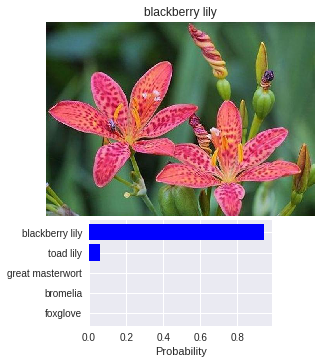

Correct classification: blackberry lily
Correct prediction: True


In [31]:
image_file = valid_dir + '/102/image_08002.jpg'
correct_class = cat_to_name['102']
image = PIL.Image.open(image_file)

top_probs, top_classes = predict(image_file,model)

label = top_classes[0]

fig = plt.figure(figsize=(6,6))
subplot_img = plt.subplot2grid((15,9), (0,0), colspan=9, rowspan=9)
subplot_preds = plt.subplot2grid((15,9), (9,2), colspan=5, rowspan=5)

subplot_img.axis('off')
subplot_img.set_title(f'{cat_to_name[label]}')

subplot_img.imshow(image)

labels = []
for class_idx in top_classes:
    labels.append(cat_to_name[class_idx])

yp = np.arange(5)
subplot_preds.set_yticks(yp)
subplot_preds.set_yticklabels(labels)
subplot_preds.set_xlabel('Probability')
subplot_preds.invert_yaxis()
subplot_preds.barh(yp, top_probs, xerr=0, align='center', color='blue')

plt.show()
print(f'Correct classification: {correct_class}')
print(f'Correct prediction: {correct_class == cat_to_name[label]}')